HSE, Applied Time Series Forecasitng , Winter 2024-25

<font color="green"> Lesson 9: Time Series Forecasting with ML </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:**
    - demand forecasting, rolling (lagged) features, time series CV

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

# Demand Time Series

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityWAPE, qualityRMSE
import warnings, pylab

warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

In [2]:
# загружаем данные
ts_retail = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep=';')
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], format= "%Y-%m-%d") #dayfirst=True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail = ts_retail.sort_index() # must have
ts_retail = ts_retail.loc['2015-01-01':'2016-05-22', :] # cut null-period
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN
2015-01-01,19,1,NaN,25.0,163.78,NaN
2015-01-01,39,2,NaN,3.0,135.78,NaN
2015-01-01,40,2,NaN,0.0,135.78,NaN
2015-01-01,18,1,NaN,13.0,163.78,NaN


In [3]:
# Draw some time series
def plot_some_ts(ts_df, groupby_columns, time_column, target_column, ts_num = 10, aggregation_method = 'sum'):
  '''pivot original ts by group_columns'''
  pivot_ts = ts_df.groupby(groupby_columns + [time_column]).agg(aggregation_method)

  # concat multiple index to single column
  index_column_name = ', '.join([groupby_columns[i]+'={0['+str(i)+']}' for i in range(len(groupby_columns))])
  pivot_ts.index = [pivot_ts.index.map(index_column_name.format) , pivot_ts.index.get_level_values(len(groupby_columns))]

  # unstack by-column (column that contains ts name)
  pivot_ts = pivot_ts.unstack([0])[target_column]

  # plot first ts_num ts
  fig = pivot_ts[pivot_ts.columns[:ts_num]].plot().update_layout(height=350, width=1300,
                                                  title="first {0} ts for {1} variable".format(ts_num, target_column ),
    xaxis_title=time_column,
    yaxis_title=target_column+ ' value',
    legend_title='ts id columns: '+', '.join(groupby_columns)).show()
  return fig

plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Demand', ts_num = 3)

In [4]:
# Fill missings  (note: step is domain specific)
ts_retail['Promo'] = ts_retail['Promo'].fillna(0)
ts_retail.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
ts_retail['Regular_Price'] = ts_retail['Regular_Price'].ffill().bfill()
ts_retail.reset_index().set_index(['Date'], inplace=True)

plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Regular_Price', ts_num = 8)

# Add actual price (promo price when promo occurred or regular price otherwise)
ts_retail['Actual_Price'] = ts_retail.Promo_Price.combine_first(ts_retail.Regular_Price)
plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Actual_Price', ts_num = 8)

In [5]:
# prepare test/train datasets
test_start_dt = '05-01-2016'
train = ts_retail.copy(deep=True)
train.loc[test_start_dt:, 'Demand'] = np.NaN
train.loc['01-01-2016':].plot()
test_y = ts_retail.loc[test_start_dt:, ['Store_id', 'SKU_id', 'Demand']]

plot_some_ts(test_y.reset_index(), ['Store_id','SKU_id'], 'Date', 'Demand', ts_num = 8)

In [ ]:
# test sample size
test_y.shape

(4532, 3)

In [6]:
# Aggregate on Sku - All Stores level
sales_by_sku = train.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Actual_Price':'mean'}).reset_index().set_index('Date').rename(columns = {'Store_id':'Store_count'})
sales_by_sku.loc[test_start_dt:,'Demand'] = np.NaN # fill test period Demand with Nan

# sales_by_sku[sales_by_sku['SKU_id'] == 1].plot()

In [7]:
# draw cross-series plot for drivers
def make_cross_series_plot(ts, columns_name, yaxis_no = [] ):
  fig = go.Figure()

  if len(yaxis_no) != len(columns_name):
    yaxis_no = list(np.array(range(len(columns_name)))+1)

  for c in range(len(columns_name[:])):
    fig.add_trace(go.Scatter(x=ts.index,
                        y=ts[columns_name[c]]
                        , name=columns_name[c],
                             yaxis='y'+str(yaxis_no[c])
                             ))
    # eval('fig.update_layout(yaxis'+str(yaxis_no[c])+'= dict(title=columns_name[c], anchor="free", overlaying="y", autoshift=True)),') # overlaying="y", side = ["left", "right"][c%2])),')

  fig.update_layout(xaxis=dict(title = 'Date', domain=[0.1, 0.95]))
  fig.show()

  return

# make_cross_series_plot(ts=sales_by_sku[sales_by_sku['SKU_id'] == 1], columns_name=['Demand', 'Promo', 'Actual_Price', 'Store_count'], yaxis_no=[1,2,3,4])


ts_sku1 = sales_by_sku[sales_by_sku['SKU_id'] == 1]

fig = go.Figure()
fig.update_layout(xaxis=dict(title = 'Date', domain=[0.1, 0.95]))
fig.add_trace(go.Scatter(x=ts_sku1.index,
                        y=ts_sku1["Demand"]
                        , name="Demand", yaxis="y1"))

fig.add_trace(go.Scatter(x=ts_sku1.index,
                        y=ts_sku1["Promo"]
                        , name="Promo", yaxis="y2"))

fig.add_trace(go.Scatter(x=ts_sku1.index,
                        y=ts_sku1["Actual_Price"]
                        , name="Actual_Price", yaxis="y3"))

fig.add_trace(go.Scatter(x=ts_sku1.index,
                        y=ts_sku1["Store_count"]
                        , name="Store_count", yaxis="y3"))


fig.update_layout(
    yaxis=dict(
        title="Demand",
    ),
    yaxis2=dict(
        title="Promo",
        overlaying="y",
        side="right",
    ),
    yaxis3=dict(
        title="Actal_Price, Store_Count",
        anchor="free",
        overlaying="y",
        autoshift=True,
    ),
)
fig.show()

In [8]:
sales_by_sku.head()

,SKU_id,Demand,Promo,Store_count,Actual_Price
Date,,,,,
2015-01-01,1,1180.0,0.0,73,163.920685
2015-01-02,1,3667.0,0.0,73,163.920685
2015-01-03,1,4987.0,0.0,73,163.920685
2015-01-04,1,5226.0,0.0,73,163.920685
2015-01-05,1,5951.0,0.0,73,163.920685


# ML for time series Forecasting

**Questions**
* Can classic ML algorithms (including DT regressor, Boosting, RF regressors)   be applied to the ts forecasting problem?
  - Yes, assuming that ts model is defined properly

* How CV should be organized for ts problem?

<img src = 'https://i2.wp.com/miro.medium.com/1*QK8DgHNx4pT-k56gR4l4iA.png' width = '2500px'>

## Feature generation for ML algorithms
**Questions**
* What features should be added to the original data set?
   - Calendar-dummy variables: holidays, day of week, day of month
   - Lagged (or rolluing)-features
   - x-sindicated features (e.g price x store_number**2)

In [11]:
# feature generation
data = sales_by_sku.reset_index().copy(deep = True)

data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data[300:].head()

,Date,SKU_id,Demand,Promo,Store_count,Actual_Price,weekday,monthday,is_weekend
300,2015-10-28,1,79231.0,87.0,87,124.178621,2,28,0
301,2015-10-29,1,56094.0,87.0,87,124.178621,3,29,0
302,2015-10-30,1,46652.0,88.0,88,124.185341,4,30,0
303,2015-10-31,1,42072.0,88.0,88,124.185341,5,31,1
304,2015-11-01,1,37146.0,88.0,88,124.185341,6,1,1


In [12]:
lag = 10
idx = data.filter
data[idx] = np.NaN
data_feature_Demand_lag10_window7_mean_Regular_Holidays = data[idx].rolling(methdod = 'mean', window = 7).shift(lag)['Demand'].
# methdod = mean, median, mode, max, min, percentile(90), std, entropy, skewnees, ewma, cumsum,

data_feature_lag1_Demand_Diff = data.diff().shift(lag)['Demand']

# causal variabel features tbd
data_feature_lag1_Price = data.shift(lag).diff()['Price']

### Lagged Features Generation

**Questions**
* Classic TS models leverage ts structure information (level, seasonaliry, trend, etc) for forecasting. How to provide such information for classsic ML models?

  - Answer: use ES forecast as features for ML  -->
     - Use more complicated ts based feature generation https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/LaggedFeaturesGeneration.PNG?raw=true'>

In [13]:
from ipywidgets import IntProgress

from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col, default_value = np.nan):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)

    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=default_value)

    results.index.rename(date_col, inplace=True)

    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    # ## fill missing dates
    # print(data_preag.head())
    # print(group_col[:-1])
    # print(date_col)
    # print(data_preag.groupby(group_col[:-1]).count())

    # data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
    #     fill_missing_dates, date_col=date_col).drop(group_col[:-1],
    #                                                 axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag # ,  data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1).reset_index(group_col)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1).reset_index(group_col[:-1])
    # print(lf_df_filled.columns)
    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        group_col[:-1]).apply(lambda x: x.shift(lag)).drop(group_col[:-1], axis=1).reset_index(group_col[:-1])
    # lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))
    # print(lf_df.index)

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:

    '''
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = [filter_col] + id_cols + [date_col]
        for preagg in preagg_methods:
          data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                  target_cols, preagg)

          # print(data.head())
          ## add ewm features
          for alpha in ewm_params.get(filter_col, []):
              ewm_filled = calc_ewm(data_preag_filled, group_col,
                                    date_col, alpha)
              for lag in lags:
                # print(filter_col, preagg, alpha, lag)
                ewm = shift(ewm_filled, group_col, date_col, lag)
                # print(ewm.columns)

                new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                    format(x, lag, alpha, '&'.join(id_cols), preagg, filter_col) for x in target_cols}
                # print(new_names)

                # print(out_df.columns)

                out_df = pd.merge(out_df,
                                  ewm.rename(columns=new_names),
                                  how='left',
                                  on=group_col)

          ## add rolling features
          for w in windows:
              for method in agg_methods:
                  rolling_filled = calc_rolling(data_preag_filled,
                                                group_col, date_col,
                                                method, w)
                  for lag in lags:
                    ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                    rolling = shift(rolling_filled, group_col, date_col, lag)

                    method_name = method.__name__ if type(
                        method) != str else method

                    new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                  format(x, lag, w, '&'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      rolling.rename(columns=new_names),
                                      how='left',
                                      on=group_col)
                    progress.value += 1

    return out_df

**Questions**
  * How to define lagges based on forecast horizon?
    - Lag must be less or equal than forecast horizon in order to prevent target leakage!
      - example: forecast horizon is equal to 22 days => minimal lag value is 22

In [14]:
target_cols = ['Demand']
id_cols = ['SKU_id']
date_col = 'Date'
built_in_funcs = [pd.Series.kurtosis, pd.Series.skew]

# flts = {'Promo': {'oprm':'>0', 'npromo':'==0', 'aprm':'>-1'}, 'weekday' : {'md':'==0', 'tue':'==1', 'wd':'==2', 'th':'==3', 'fr':'==4', 'sa':'==5', 'su':'==6', 'anyday':'>-1'}}


data['NoFilter'] = 1
data_lagged_features = generate_lagged_features(data
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [22, 28, 35] # min(lags)>= forecast horizon!
                    , windows = ['14D', '21D', '28D', '56D']
                    , preagg_methods = ['sum'] # ['mean', 'count']
                    , agg_methods = ['mean', percentile(10),  percentile(90)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [14, 28], 'Promo': [14, 28]}
                    )

IntProgress(value=0, max=72)

In [15]:
# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

94


Index(['Date', 'SKU_id', 'Demand', 'Promo', 'Store_count', 'Actual_Price',
       'weekday', 'monthday', 'is_weekend', 'NoFilter',
       'Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag28d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag35d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag28d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag35d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag28d_w14D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag35d_w14D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag28d_w14D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag35d_w14D_keySKU_id_preagsum_agpctl10_Promo_dynam

## ML model definition
**Questions**
* Shall we train only one model for all data?

<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Informativity.png?raw=true' width=1200px height = 600px>

 See details here
http://www.machinelearning.ru/wiki/images/3/3e/Voron-ML-Logic.pdf

* Can we define ML pipeline based on business logics?

In [16]:
# put date in index
data_lagged_features.set_index('Date', inplace = True)
data_lagged_features.loc[test_start_dt:].head()

,SKU_id,Demand,Promo,Store_count,Actual_Price,weekday,monthday,is_weekend,NoFilter,Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm,...,Demand_lag35d_w28D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag22d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag22d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag22d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-01,1,NaN,0.0,103,131.16,6,1,1,1,15268.911578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01,2,NaN,0.0,103,138.50,6,1,1,1,365.487342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-02,2,NaN,0.0,103,138.50,0,2,0,1,356.622363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-02,1,NaN,0.0,103,131.16,0,2,0,1,15044.923367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-03,2,NaN,103.0,103,106.01,1,3,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# train specific model for each SKU
sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

## ML Model Training

In [18]:
sku1_train.sort_values(by = 'Demand', ascending = False)

,SKU_id,Demand,Promo,Store_count,Actual_Price,weekday,monthday,is_weekend,NoFilter,Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm,...,Demand_lag35d_w28D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag22d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag22d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag22d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-24,1,194991.0,91.0,91,116.61,1,24,0,1,NaN,...,49484.6,30544.089286,30544.089286,30544.089286,13887.5,13887.5,13887.5,51312.0,51312.0,51312.0
2015-11-25,1,162298.0,91.0,91,116.61,2,25,0,1,NaN,...,49484.6,33094.464286,33094.464286,33094.464286,13887.5,13887.5,13887.5,55841.0,55841.0,55841.0
2016-04-19,1,148154.0,98.0,98,122.32,1,19,0,1,NaN,...,NaN,27661.428571,27661.428571,NaN,13939.5,13939.5,NaN,63263.5,63263.5,NaN
2015-03-17,1,142685.0,74.0,74,127.49,1,17,0,1,NaN,...,61321.8,23657.696429,23657.696429,23657.696429,8402.5,8402.5,8402.5,41620.5,41620.5,41620.5
2015-04-07,1,137637.0,75.0,75,119.33,1,7,0,1,NaN,...,100794.0,34620.285714,34620.285714,34620.285714,14364.5,14364.5,14364.5,69797.0,69797.0,69797.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,1,NaN,103.0,103,119.60,2,18,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-19,1,NaN,103.0,103,119.60,3,19,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20,1,NaN,103.0,103,119.60,4,20,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# try lightgbm as ml algorithm
!pip install lightgbm
import lightgbm as lgb
# kwargs={'verbose':2}

def plot_feature_importance(model, X , num = 20):
  import seaborn as sns
  import matplotlib.pyplot as plt
  sns.set_style("darkgrid")
  sns.mpl.rc("figure", figsize=(25, 5))
  sns.mpl.rc("font", size=14)

  feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                      ascending=False)[0:num])
  plt.title('LightGBM Features (avg over folds)')
  # plt.tight_layout()
  # plt.savefig('lgbm_importances-01.png')
  plt.show()

In [20]:
# without CV
lgbm1 = lgb.LGBMRegressor(
                        n_estimators=100,
                        learning_rate=0.1,
                        feature_fraction=0.3,
                        subsample=0.2,
                        num_leaves=10,
                        metric='mae', force_col_wise=True)
callbacks = [lgb.early_stopping(10, verbose=2)]

lgbm1.fit(X = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1),
          y = sku1_train.loc[:test_start_dt].Demand) #,callbacks = callbacks)

lgbm2 = lgb.LGBMRegressor(
                        n_estimators=100,
                        learning_rate=0.1,
                        feature_fraction=0.3,
                        subsample=0.2,
                        num_leaves=10,
                        metric='mae', force_col_wise=True)

lgbm2.fit(X = sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1),
          y = sku2_train.loc[:test_start_dt].Demand) # callbacks = callbacks)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Total Bins 9399
[LightGBM] [Info] Number of data points in the train set: 487, number of used features: 90
[LightGBM] [Info] Start training from score 31271.067762
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Total Bins 9446
[LightGBM] [Info] Number of data points in the train set: 487, number of used features: 90
[LightGBM] [Info] Start training from score 1170.817248


LGBMRegressor(feature_fraction=0.3, force_col_wise=True, metric='mae',
              num_leaves=10, subsample=0.2)

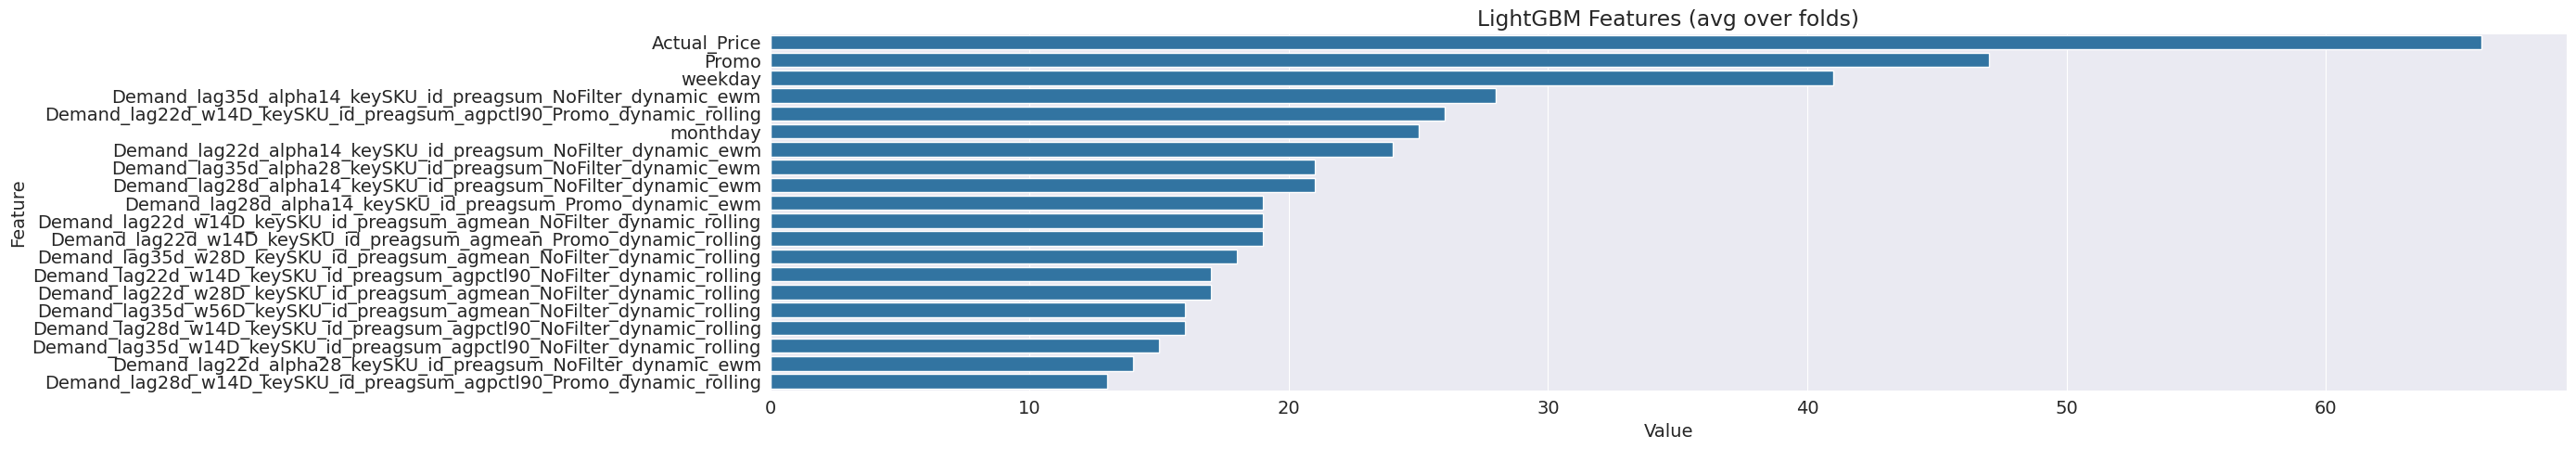

In [21]:
plot_feature_importance(lgbm1, sku1_train[sku1_train.columns[2:]], num = 20)

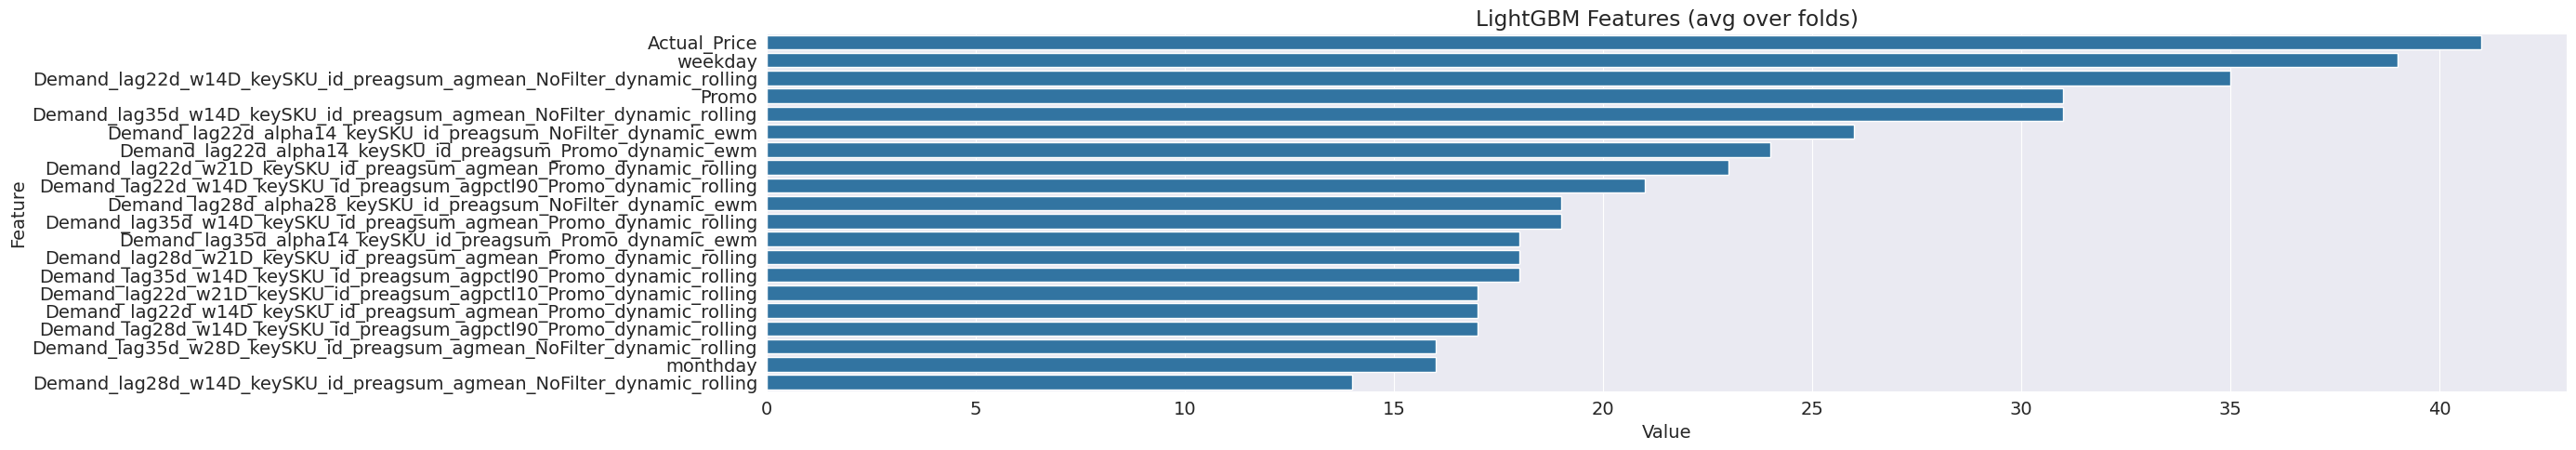

In [22]:
# caution: syndicated data!
plot_feature_importance(lgbm2, sku2_train[sku2_train.columns[2:]], num = 20)

### Cross-validation for time series
 **Caution**: ml parameters tuning steps are omitted! Only tech approach is shown.

In [23]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

In [24]:
# Train sets
X_train1 = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1)
X_test1 = sku1_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)
y_train1 = sku1_train.loc[:test_start_dt].Demand

X_train2 = sku2_train.loc[:test_start_dt].drop(['SKU_id', 'Demand'], axis=1)
X_test2 = sku2_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)
y_train2 = sku2_train.loc[:test_start_dt].Demand

In [25]:
# test sets
X_test1 = sku1_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)
X_test2 = sku2_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)

In [26]:
print(len(X_train1.columns))
print(len(X_test1.columns))
X_test1.columns

91
91


Index(['Promo', 'Store_count', 'Actual_Price', 'weekday', 'monthday',
       'is_weekend', 'NoFilter',
       'Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag28d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag35d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag28d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag35d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag28d_w14D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag35d_w14D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag28d_w14D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag35d_w14D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_

In [27]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [28]:
# run TS CV for the sku 1 (if needed)
%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm1, wape)

Size train set: (487, 91)
Size of each fold: 28

Splitting the first 2 chunks at 1/2
Size of train and test: (56, 91)
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 28, number of used features: 0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Start training from score 6906.142857
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [

42.1608602423413

In [29]:
# run TS CV for the sku 2 (if needed)
%%time
performTimeSeriesCV(X_train2, y_train2, 17, lgbm2, wape) #, kwargs)

Size train set: (487, 91)
Size of each fold: 28

Splitting the first 2 chunks at 1/2
Size of train and test: (56, 91)
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 28, number of used features: 0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Start training from score 223.571429
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

49.37550312573015

## Forecast Generation with ML

In [30]:
# forecast for sku 1
y_pred_sku1 = lgbm1.predict(X_test1)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


In [31]:
# plot forecast cross-series plot
fig = go.Figure()
fig.update_layout(xaxis=dict(title = 'Date', domain=[0.1, 0.95]))
fig.add_trace(go.Scatter(x=X_test1.index,
                         y=y_pred_sku1,
                         name="Forecast", yaxis="y1"))

fig.add_trace(go.Scatter(x=X_test1.index,
                        y=X_test1["Promo"]
                        , name="Promo", yaxis="y2"))

fig.add_trace(go.Scatter(x=X_test1.index,
                        y=X_test1["Actual_Price"]
                        , name="Actual_Price", yaxis="y3"))

fig.update_layout(
    yaxis=dict(
        title="Forecast",
    ),
    yaxis2=dict(
        title="Promo",
        overlaying="y",
        side="right",
    ),
    yaxis3=dict(
        title="Actal_Price",
        anchor="free",
        overlaying="y",
        autoshift=True,
    ),
)
fig.show()

In [32]:
# forecast for sku 2
y_pred_sku2 = lgbm2.predict(X_test2)

# plot forecast cross-series plot
fig = go.Figure()
fig.update_layout(xaxis=dict(title = 'Date', domain=[0.1, 0.95]))
fig.add_trace(go.Scatter(x=X_test2.index,
                         y=y_pred_sku2,
                         name="Demand", yaxis="y1"))

fig.add_trace(go.Scatter(x=X_test2.index,
                        y=X_test2["Promo"]
                        , name="Promo", yaxis="y2"))

fig.add_trace(go.Scatter(x=X_test2.index,
                        y=X_test2["Actual_Price"]
                        , name="Actual_Price", yaxis="y3"))

fig.update_layout(
    yaxis=dict(
        title="Demand",
    ),
    yaxis2=dict(
        title="Promo",
        overlaying="y",
        side="right",
    ),
    yaxis3=dict(
        title="Actal_Price",
        anchor="free",
        overlaying="y",
        autoshift=True,
    ),
)
fig.show()

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


**Note**: forecast highly depends on key drivers

In [33]:
y_true = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index().set_index('Date')

# WAPE for sku 1
qlt , _ = qualityWAPE(y_true[y_true['SKU_id']==1]['Demand'], y_pred_sku1)

#draw forecast and actuals
pd.DataFrame.from_dict({'y_pred':y_pred_sku1, 'Date':X_test1.index}).set_index('Date').\
  merge(y_true[y_true['SKU_id']==1], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].\
  plot(title = 'WAPE='+str(qlt))

In [34]:
# WAPE for sku 2
qlt , _ = qualityWAPE(y_true[y_true['SKU_id']==2]['Demand'], y_pred_sku2)

#draw forecast and actuals
pd.DataFrame.from_dict({'y_pred':y_pred_sku2, 'Date':X_test2.index}).set_index('Date').\
  merge(y_true[y_true['SKU_id']==2], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].\
  plot(title = 'WAPE='+str(qlt))

**Materials**
* Cross-validation for time series https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
* M - competition
  - M6: https://www.unic.ac.cy/iff/research/forecasting/m-competitions/m6/
  - M5: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163414
  - M4: https://www.sciencedirect.com/science/article/pii/S0169207019301128
